In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from itertools import *

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import files

In [4]:
def sum_of_squares(samples: np.ndarray) -> float:
    return ((samples - samples.mean()) ** 2).sum()

In [5]:
# uploaded = files.upload()

# for fn in uploaded.keys():
#    print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

In [6]:
PATH = 'drive/MyDrive/СпецПрога/3 analysis/train.csv'
df = pd.read_csv(PATH)
df.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


In [7]:
df.drop(columns=['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'store_and_fwd_flag'], inplace=True)

In [8]:
df.shape

(1458644, 6)

# Анализ

Обратим внимание на ряд числовых показателей:

*   `passenger_count` - кол-во пассажиров
*   `pickup_longitude` - долгота координаты посадки
*   `pickup_latitude` - широта координаты посадки
*   `dropoff_longitude` - долгота координаты высадки
*   `dropoff_latitude` - широта координаты высадки
*   `trip_duration` - продолжительность поездки, сек

Средния значения координат близки к медианным, чего нельзя сказать о продолжительности поездки и кол-ве пассажиров. Можно сделать вывод, что чаще всего такси пользуются в одиночку для непродолжительных поездок. 

Среди координат наибольшее различия медианы и среднего имеют данные долготы:   0.0008 для pickup и 0.0006 для dropoff. Это можно объяснить тем, что такси используется чаще в левой части города. (Далее мы убедимся, что это действительно так и в Нью-Йорке такси более популярно на Манхэттэне)


In [9]:
df.describe()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


Убедимся в отсутствии пропущенных значений

In [10]:
df.isna().sum()

passenger_count      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
trip_duration        0
dtype: int64

Удалим из данных поездки длительностью более 1 часа (7200 секунд) и менее 2 минут (120 секунд), а также обрежем координаты поездок так, чтобы они интуитивно лежали в пределах 1го города (возьмем +- 0.1 единиц широты и долготы от медианы)

In [11]:
print(df.shape[0])
df = df[(df['trip_duration'] < 7200) & (df['trip_duration'] > 120)]
df = df[(df['pickup_longitude'] < -73.9) & (df['pickup_longitude'] > -74.1)]
df = df[(df['pickup_latitude'] < 40.86) & (df['pickup_latitude'] > 40.66)]
df = df[(df['dropoff_longitude'] < -73.9) & (df['dropoff_longitude'] > -74.1)]
df = df[(df['dropoff_latitude'] < 40.86) & (df['dropoff_latitude'] > 40.66)]

print(df.shape[0])

1458644
1300249


In [122]:
# Наиболее популярные точки посадки и высадки такси в Нью-Йорке - центр Манхэттэна

print(df['pickup_latitude'].round(6).mode()[0], df['pickup_longitude'].round(6).mode()[0])
print(df['dropoff_latitude'].round(6).mode()[0], df['dropoff_longitude'].round(6).mode()[0])

40.751179 -73.982201
40.750118 -73.98233


###Пользуясь данными координат, добавим километраж поездок

In [12]:
def haversine_array(lat1, lng1, lat2, lng2): # считаем расстояние между двумя точками (Земля круглая - и дороги не прямые)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def manhattan_distance(lat1, lng1, lat2, lng2): # разбиваем путь на манхэттенские улицы
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

df['distance_haversine'] = haversine_array(df['pickup_latitude'].values, df['pickup_longitude'].values, df['dropoff_latitude'].values, df['dropoff_longitude'].values)
df['distance_manhattan'] = manhattan_distance(df['pickup_latitude'].values, df['pickup_longitude'].values, df['dropoff_latitude'].values, df['dropoff_longitude'].values)


In [13]:
df.drop(columns=['distance_haversine'], inplace=True)

## Проверка данных на нормальное распределение

### Визуальный анализ (гистограммы)

Построим гистограммы интеерсующих нас признаков, а также наложим поверх гистограм то, как бы выглядело нормальное распределение с параметрами, рассчитанными на основе выборок.

Мы можем видеть, что данные координат распределены нормально, чего нельзя сказать о длительности и километраже поездки.



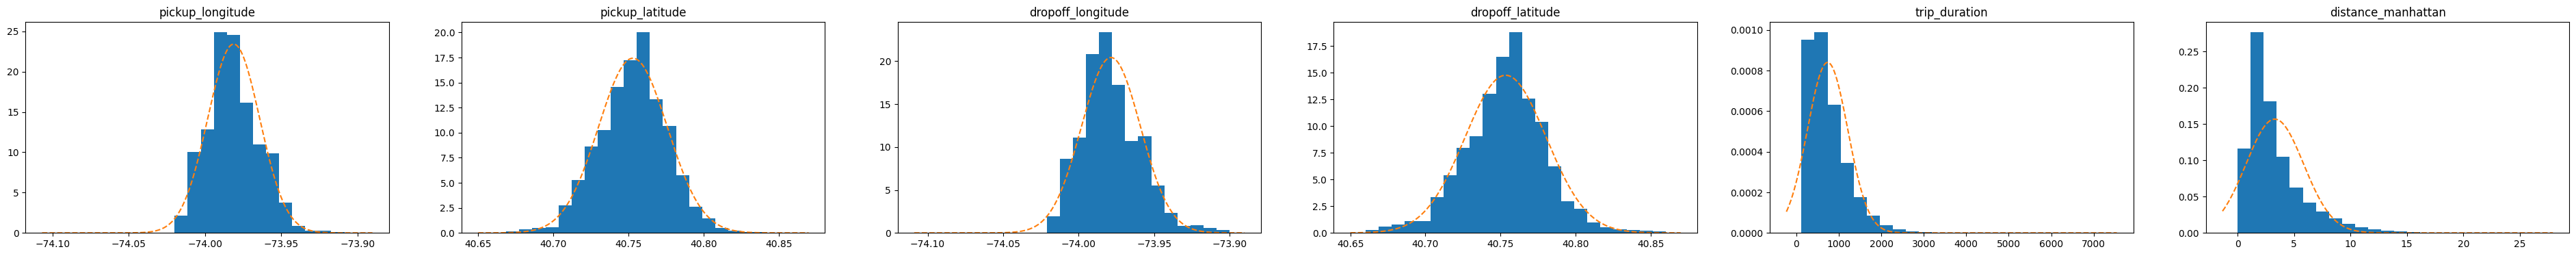

In [14]:
keys = df.select_dtypes(include=['int64', 'float64']).columns.values
keys = list(keys)
keys.remove('passenger_count')

fig, axes = plt.subplots(ncols=len(keys))
fig.set_size_inches(8 * len(keys), 4)
axes = axes.flatten()

for key, ax in zip(keys, axes):
    ax.hist(df[key], density=True, bins=23)
    
    loc = df[key].mean()
    scale = df[key].std()
    
    x_left, x_right = ax.get_xlim()
    x = np.linspace(x_left, x_right, 10000)
    y = stats.norm.pdf(x, loc=loc, scale=scale)
    
    ax.plot(x, y, linestyle='dashed')
    ax.set_title(key)

Видно, что распределения продолжительности и километража похожи на нормальные, однако скошены. Вычислим коээфициент ассиметрии

In [96]:
from scipy.stats import skew

print(f'{skew(df["trip_duration"])} > 0 --> распределение скошено влево', '\n'
      f'{skew(df["distance_manhattan"])} > 0 --> распределение скошено влево', '\n'
      f'{skew(df["dropoff_latitude"])} ~ 0 --> распределение не скошено')

1.6531395451080264 > 0 --> распределение скошено влево 
1.8327861262351444 > 0 --> распределение скошено влево 
-0.04496854370987012 ~ 0 --> распределение не скошено


### Визуальный анализ (квантили)

Построим Q-Q кривую. Это график, который показывает соответствие между теоретическим значением квантиля на выборке и его реальным значением. 

Чем ближке график к графику $y=x$, тем более нормальным является распределение значений выборки. 

Признаки `distance_manhattan` и `trip_duration` не являются распределёнными нормально. Тогда как данные координат распределены относительно нормально.

0it [00:00, ?it/s]

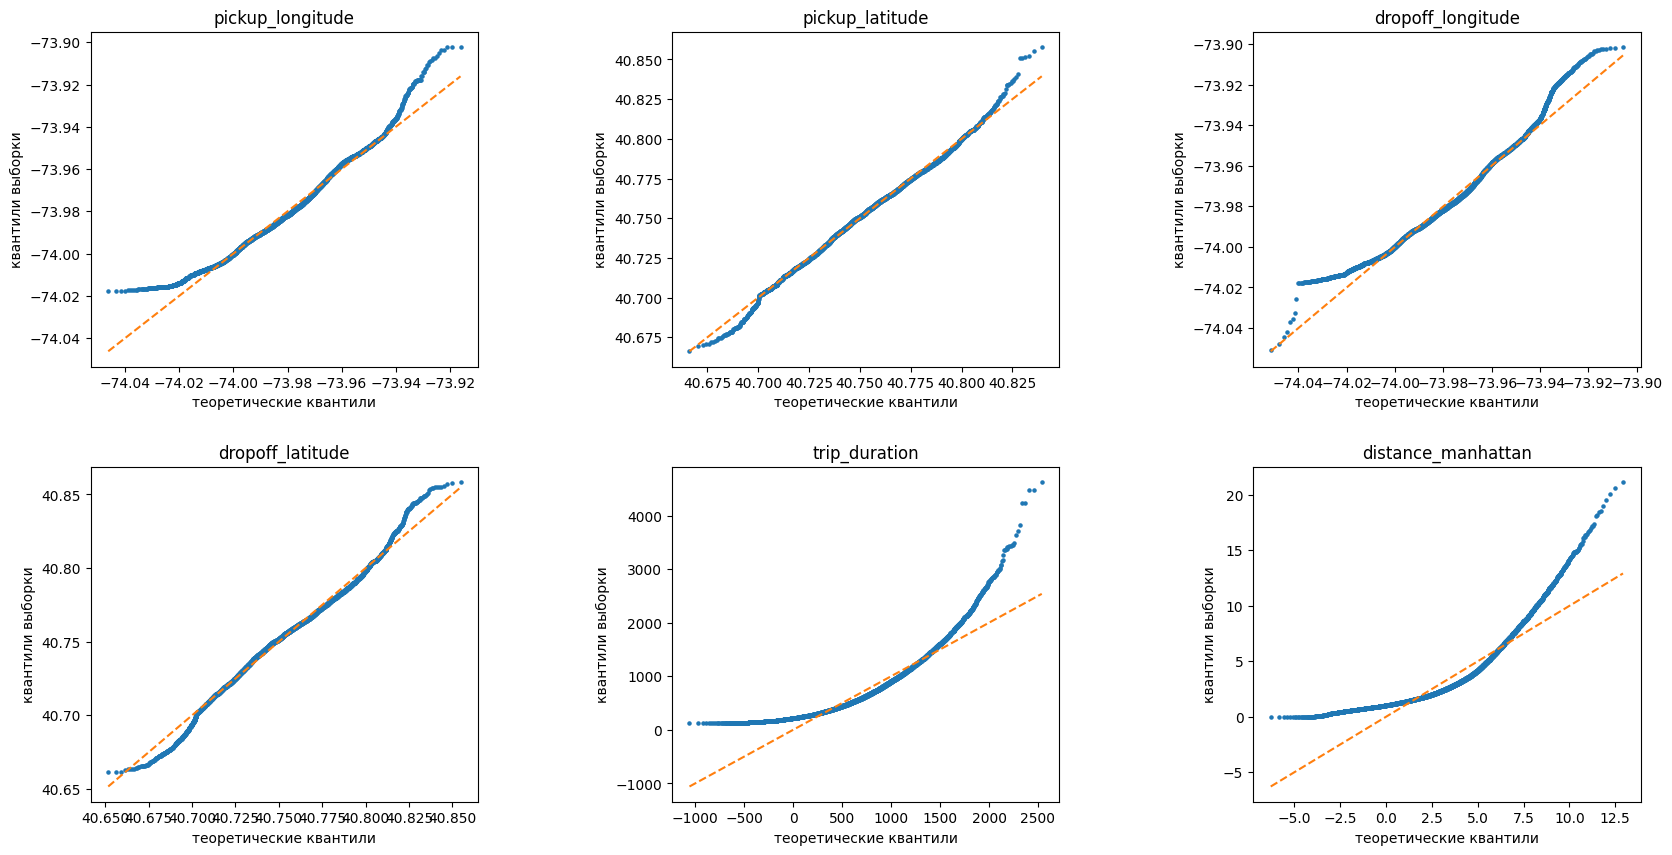

In [15]:
from tqdm.notebook import tqdm
fig, axes = plt.subplots(2, 3)
plt.subplots_adjust(wspace=0.5, hspace=0.3)
fig.set_size_inches(20, 10)
axes = axes.flatten()

cur_df = df[df.index % 100 == 0]
for key, ax in tqdm(zip(keys, axes)):
    samples = cur_df[key]
    
    loc = samples.mean()
    scale = samples.std()
    
    interval = np.linspace(0, 1, samples.shape[0])[1:-1]
    x = stats.norm.ppf(interval, loc=loc, scale=scale)
    y = np.quantile(samples, interval)
    
    ax.scatter(x, y, s=5)
    ax.plot(x, x, color='C1', linestyle='dashed')
    ax.set_title(key)
    ax.set_xlabel('теоретические квантили')
    ax.set_ylabel('квантили выборки')

### Стастические показатели для выборок

Оценим нормальность выборок также  на основании известных характеристик нормального распределения. В частности:
* Вероятность попасть в интервал от $\mu - \sigma$ до $\mu + \sigma$ равна $0.68$,
* В интервал от $\mu - 2\sigma$ до $\mu + 2\sigma$ — $0.95$,
* В интервал от $\mu - 3\sigma$ до $\mu + 3\sigma$ — $0.997$.

Если рассчётные цифры оказываются близки к теоретическим, то распределения можно признать нормальными. 

Тот факт, что распределения данных значений явлются нормальными или близкими к ним позволяет использовать другие методы для анализа взаимосвязей в данных.

Видно, что данные долготы более похожи на нормальное распределение, чем данные широты, что говорит о том, что город вытянут сверху вниз (данные широты более сильно "размазаны", чем данные долгоды). И действительно, рассматриваемый город Нью-Йорк (Манхэттэн) вытянут сверху вниз. 

In [16]:
for key in keys:
    print(key)
    
    samples = df[key]
    
    loc = samples.mean()
    scale = samples.std()

    for i in range(1, 4):
        true_value = stats.norm.cdf(i) - stats.norm.cdf(-i)
        sample_value = ((samples >= loc - i * scale) & (samples <= loc + i * scale)).sum() / samples.shape[0]
        
        print(f'{i} sigma(s)')
        print(f'\ttheoretical:\t{true_value}')
        print(f'\tsample:\t\t{sample_value}')
        
    print()

pickup_longitude
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.6689580226556606
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.968332988527582
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9944187613295608

pickup_latitude
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.6823969870386365
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.95495708898834
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.993096706861532

dropoff_longitude
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.6746707745977886
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9675439088974497
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9899711516794091

dropoff_latitude
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.7125581330960454
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9493404724787329
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9898119514031544

trip_duration
1 sigma(s)
	theoretical:	0.682689492137085

Действительно, видим, что основная локация посадки (Манхэттэн) вытянута сверху вниз (дельта 0.150 по широте и 0.1 по долготе)

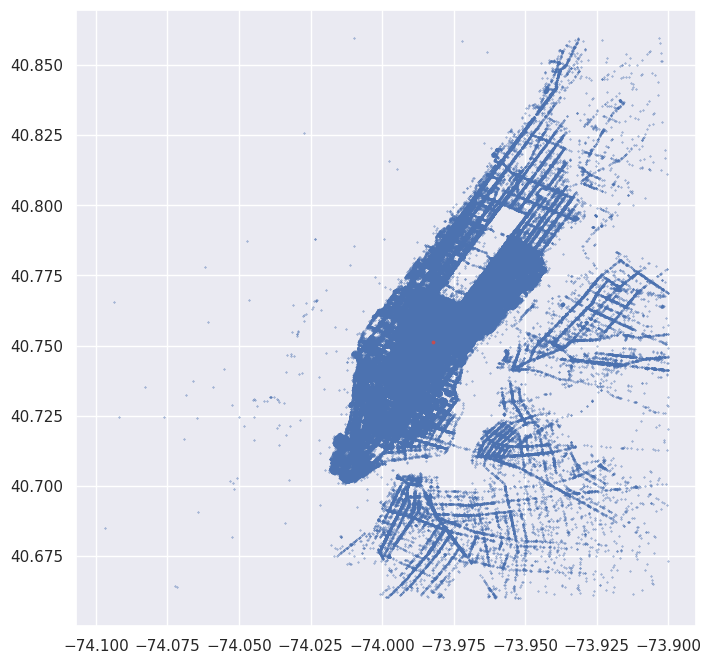

In [119]:
plt.scatter(df['pickup_longitude'], df['pickup_latitude'], s=0.1)
plt.scatter([-73.98212], [40.75116], s=3, c='r')

## Регрессия между длительностью и километражом, есть ли?

### Визуализация 

Посмотрим на зависимость длительности поездки от километража

In [18]:
df.shape

(1300249, 7)

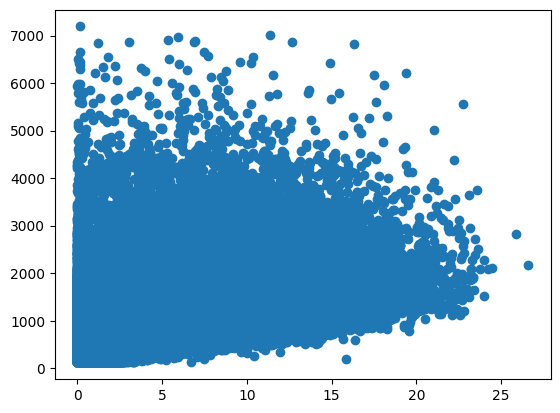

In [19]:
plt.scatter(df['distance_manhattan'], df['trip_duration'])
plt.show()

### Рассчёт регрессии и проверка значимости

Рассчитываем коэффициенты регрессии и изначения для каждого из значений выборок. Результат расчёта показывает, что регрессия неплохо описывает зависимость между данными и скорее всего зависимость есть.

In [23]:
ones = np.ones((1300249,1))
x_pot = np.hstack((ones, df['distance_manhattan'].values.reshape(1300249,1)))

In [24]:
XTX = x_pot.T.dot(x_pot)
XTX_inv = np.linalg.inv(XTX)

b = XTX_inv.dot(x_pot.T).dot(df['trip_duration'])
z = x_pot.dot(b)
e = df['trip_duration'] - z

In [25]:
R = 1 - sum_of_squares(e) / sum_of_squares(np.array(df['trip_duration']))
R

0.4394649572926155

### Визуализация зависимости 

Визуализировав зависимость мы и вправду видим некоторую связь между продолжительностью и долготой посадки (для наглядности переведем продолжительность из секунд в минуты)

In [83]:
b1 = np.cov(df['trip_duration'] / 60, df['distance_manhattan'], ddof=1)[0, 1] / np.var(df['trip_duration'] / 60, ddof=1)
b0 = df['distance_manhattan'].mean() - b1 * (df['trip_duration'] / 60).mean()

In [84]:
print(b0, b1)

0.6808393924147484 0.2132035714665031


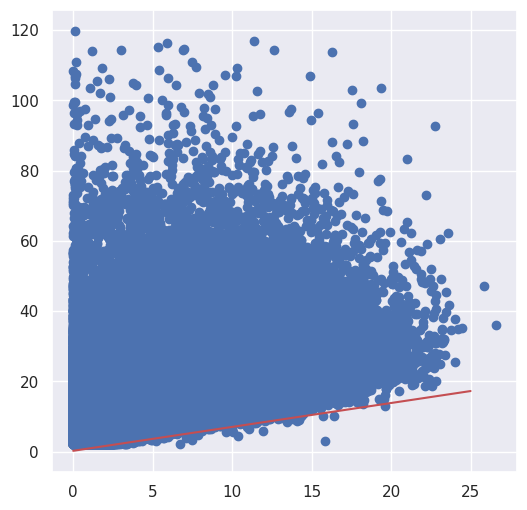

In [85]:
plt.figure(figsize=(6, 6))
plt.scatter(df['distance_manhattan'], df['trip_duration'] / 60)
x = np.linspace(0, 25, 100)
y = b0*x + b1
plt.plot(x, y, color = 'r')
plt.show()

##Корреляции

Видим, что данные координат коррелируют между собой, а также, что в приципе логично, коррелируют продолжительность поездки и километраж (чем длиннее поездка, тем она продолжительнее)

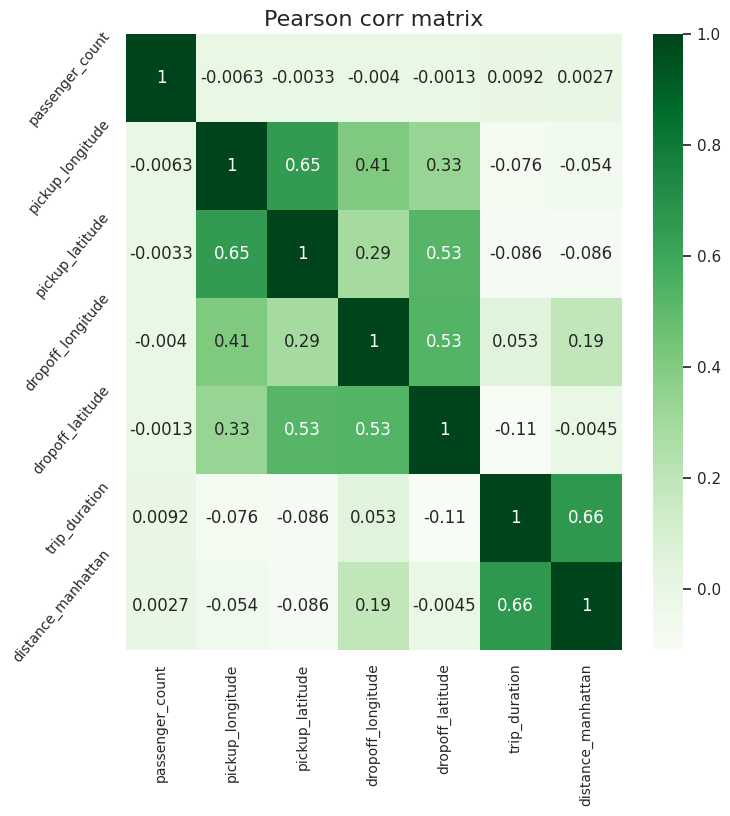

In [52]:
# Корреляция Пирсона

sns.set(rc={'figure.figsize':(8, 8)})
sns.heatmap(df.corr(), annot=True, cmap="Greens")
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10, rotation=50)
plt.title("Pearson corr matrix", fontsize=16)
plt.show()

/usr/local/lib/python3.9/dist-packages/scipy/stats/_stats_py.py:5278: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


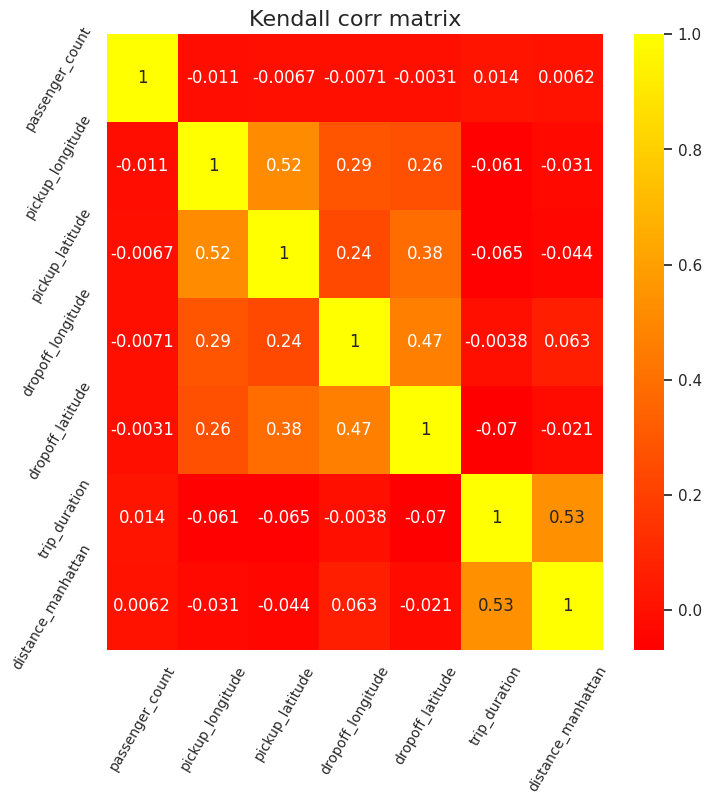

In [53]:
# Корреляция Кендалла

sns.set(rc={'figure.figsize':(8, 8)})
sns.heatmap(df.corr(method='kendall'), annot=True, cmap="autumn")
plt.xticks(fontsize=10, rotation=60)
plt.yticks(fontsize=10, rotation=60)
plt.title("Kendall corr matrix", fontsize=16)
plt.show()

# Выводы

Как бы нам не хотелось обратного, подвоха внутри нет. Данные координат распределены нормально, продолжительность поездок и их километраж подчиняются закону распределения с ассиметрией больше нуля. Это позволяет провести дисперсионный анализ различных закономерностей и выявить, что в Нью-Йорке такси более популярно на Манхэттэне.

Чаще всего люди используют такси в одиночку для непродолжительных поездок (возможно, от дома до работы и наоборот). 

Также мы убедились в том, что время поездки зависит линейно от километража и таксисты не занимаются систематическим накручиванием времени для коротких поездок. 

